# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint

## Import and define functions

In [252]:
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [253]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [254]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [333]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def root_mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the root mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        root mean square error between observed and estimated values
    """
    return np.sqrt(np.mean((observed - estimated) ** 2))

def mean_square_error(observed, estimated, **kwargs):
    """
    Calculates the mean square error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean square error between observed and estimated values
    """
    return np.mean((observed - estimated) ** 2)

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors", hue=None):
    g = sns.FacetGrid(data, col=predictors_column, col_wrap=4, hue=hue, height=4)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings

In [407]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star",
    "lbi-delta_frequency",
    "lbi-dms_star",
    "lbi-ep_x-ne_star"
]

In [257]:
data_root = "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data

In [258]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv")

In [342]:
model_jsons = glob.glob(data_root + "models/*.json")

In [343]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [344]:
models_by_predictors["lbi"]["cost_function"]

'sse'

In [345]:
models_by_predictors["lbi"]["l1_lambda"]

0.0

In [346]:
models_by_predictors["lbi"]["training_window"]

6

In [347]:
models_by_predictors.keys()

dict_keys(['dms_star', 'lbi', 'lbi-ep_x-ne_star', 'ne_star', 'lbi-dms_star', 'delta_frequency', 'cTiterSub_x', 'ep_x', 'lbi-delta_frequency', 'naive'])

In [348]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [349]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [350]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

70

In [351]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [352]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[1.0256055983599108]

In [353]:
len(models_by_predictors["lbi"]["scores"])

7

Build data frames for plotting from the model scores.

In [354]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)
        
        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["frequency"] - residual_df["frequency_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors
        residuals_dfs.append(residual_df)

overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [355]:
training_y.head()

,clade_membership,frequency,timepoint
0,0ecbd50,1.000002,2007-10-01
1,12a2869,0.000000,2007-10-01
2,253d8b1,0.000000,2007-10-01
3,4432d6c,0.000000,2007-10-01
4,61436b3,0.000000,2007-10-01


In [356]:
training_y_hat.head()

,clade_membership,frequency,timepoint
0,0ecbd50,0.841690,2007-10-01
1,12a2869,0.000001,2007-10-01
2,253d8b1,0.001645,2007-10-01
3,4432d6c,0.004754,2007-10-01
4,61436b3,0.000674,2007-10-01


In [357]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,2f64328,0.000000,2004-10-01,0.072527,-0.072527,2011-10-01,dms_star
1,66684e0,0.000000,2004-10-01,0.004723,-0.004723,2011-10-01,dms_star
2,84dfd90,0.000227,2004-10-01,0.020424,-0.020197,2011-10-01,dms_star
3,8f3fc76,0.018687,2004-10-01,0.120410,-0.101723,2011-10-01,dms_star
4,dffb0cc,0.000000,2004-10-01,0.013805,-0.013805,2011-10-01,dms_star


In [358]:
residual_df.shape

(12270, 7)

In [359]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0fdda1d,0.000000,2011-10-01,0.000978,0.001061,-0.000978,0.000000,0.921314,2011-10-01,dms_star
1,192d067,0.000005,2011-10-01,0.058473,0.052599,-0.058468,0.000095,1.111670,2011-10-01,dms_star
2,1cae6ee,0.000000,2011-10-01,0.000091,0.000103,-0.000091,0.000000,0.882556,2011-10-01,dms_star
3,1de1231,0.241074,2011-10-01,0.321393,0.292106,-0.080319,0.825296,1.100262,2011-10-01,dms_star
4,3c30c21,0.000000,2011-10-01,0.004243,0.004617,-0.004243,0.000000,0.919007,2011-10-01,dms_star


In [360]:
overall_errors_df.sort_values("cv_error_mean")

,cv_error_mean,cv_error_std,predictors
1,0.295691,0.200811,lbi
4,0.303656,0.224208,lbi-dms_star
5,0.332307,0.240936,delta_frequency
8,0.338346,0.244644,lbi-delta_frequency
6,0.348748,0.223717,cTiterSub_x
0,0.353969,0.231497,dms_star
7,0.358063,0.235699,ep_x
9,0.360194,0.230072,naive
3,0.372064,0.238055,ne_star
2,0.462523,0.196765,lbi-ep_x-ne_star


In [361]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint
0,dms_star,0.130118,19,2011-10-01
1,dms_star,0.554145,16,2012-04-01
2,dms_star,0.598105,19,2012-10-01
3,dms_star,0.155847,15,2013-04-01
4,dms_star,0.068083,14,2013-10-01


In [362]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0fdda1d,0.000000,2011-10-01,0.000978,0.001061,-0.000978,0.000000,0.921314,2011-10-01,dms_star
1,192d067,0.000005,2011-10-01,0.058473,0.052599,-0.058468,0.000095,1.111670,2011-10-01,dms_star
2,1cae6ee,0.000000,2011-10-01,0.000091,0.000103,-0.000091,0.000000,0.882556,2011-10-01,dms_star
3,1de1231,0.241074,2011-10-01,0.321393,0.292106,-0.080319,0.825296,1.100262,2011-10-01,dms_star
4,3c30c21,0.000000,2011-10-01,0.004243,0.004617,-0.004243,0.000000,0.919007,2011-10-01,dms_star


## Summarize future frequencies per timepoint

In [363]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum() > 0.9999).sum()

70

In [364]:
frequency_df.groupby(["predictors", "timepoint"])["frequency_init"].sum().shape

(70,)

In [365]:
(frequency_df.groupby(["predictors", "timepoint"])["frequency"].sum() > 0.9999).sum()

40

In [366]:
frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum()

timepoint
2011-10-01    0.991572
2012-04-01    0.999686
2012-10-01    0.995549
2013-04-01    0.999946
2013-10-01    1.000004
2014-04-01    1.000002
2014-10-01    0.999980
Name: frequency, dtype: float64

(0.9, 1.01)

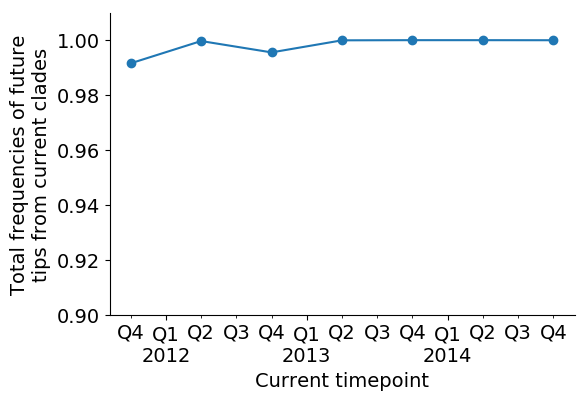

In [367]:
ax = frequency_df[frequency_df["predictors"] == "lbi"].groupby(["timepoint"])["frequency"].sum().plot(marker="o")
ax.set_xlabel("Current timepoint")
ax.set_ylabel("Total frequencies of future\ntips from current clades")
ax.set_ylim(0.9, 1.01)

## Summarize standardized predictor distributions

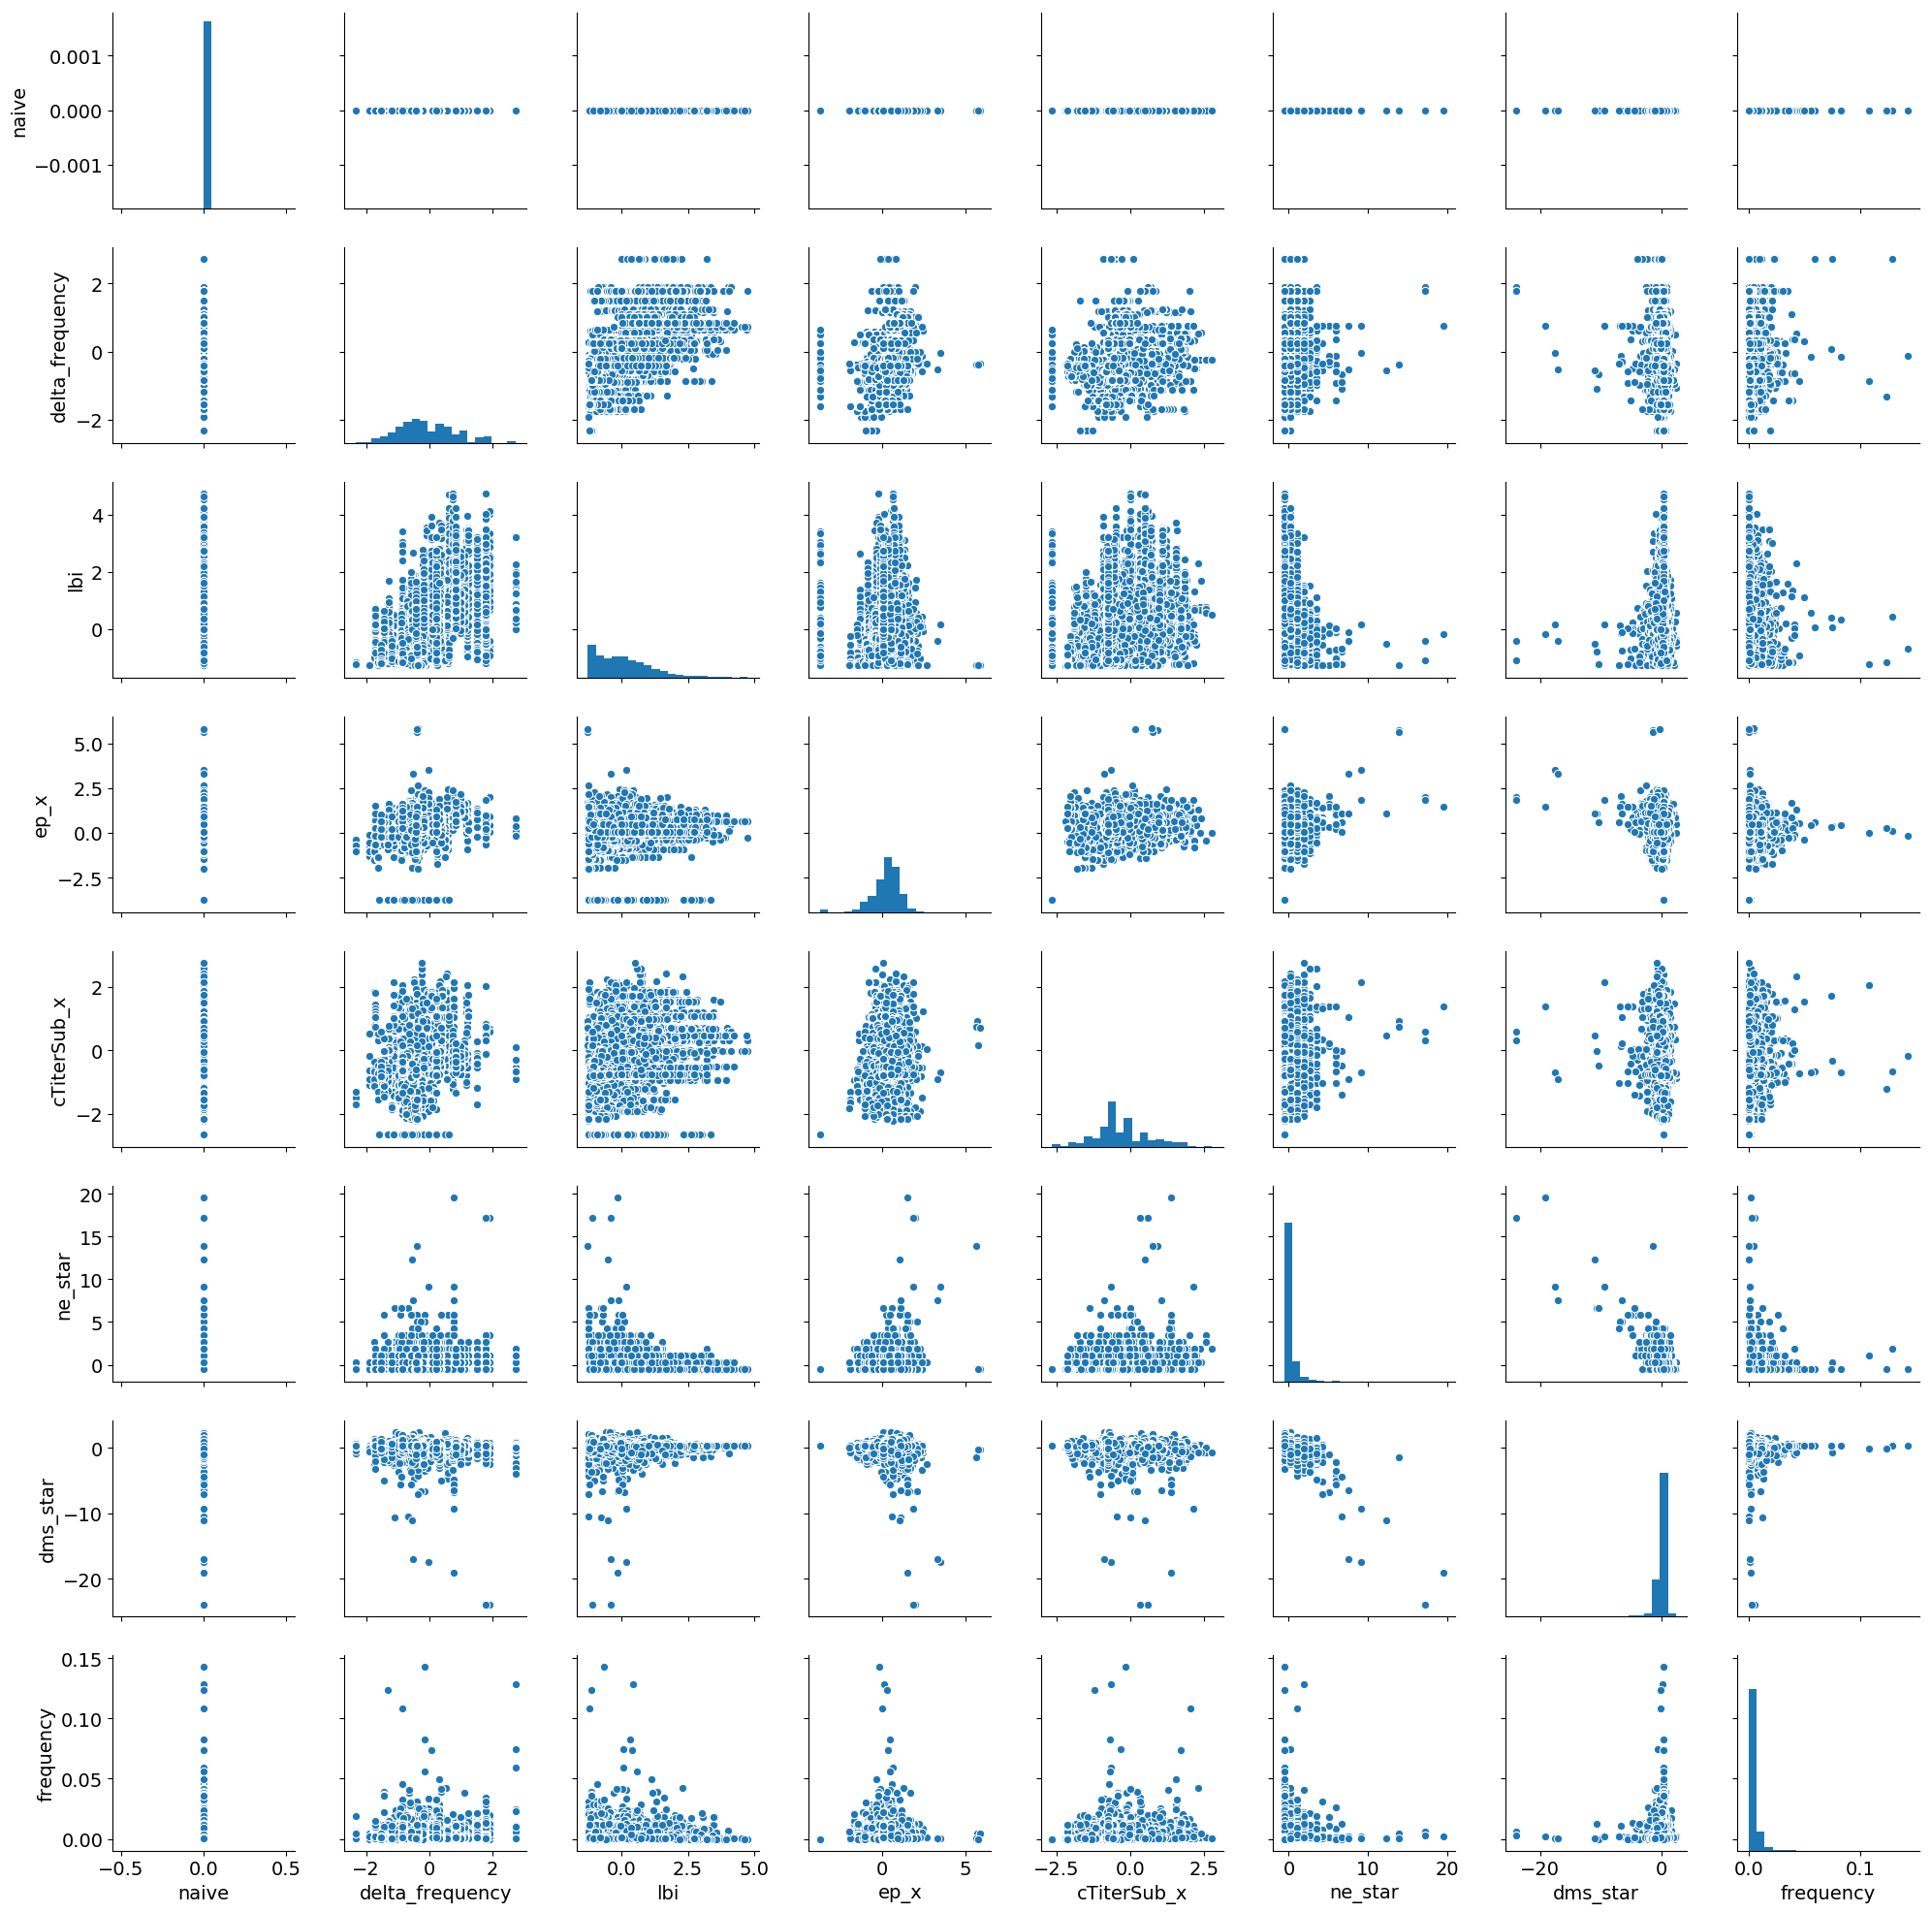

In [285]:
variables_to_plot = [predictor for predictor in predictor_names_order if not "-" in predictor] + ["frequency"]
sns.pairplot(tip_attributes_df, vars=variables_to_plot, diag_kind="hist", diag_kws={"bins": 20})

## Summarize model residuals

In [368]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [369]:
residuals_by_timepoint.head()

,predictors,timepoint,residual
0,cTiterSub_x,2004-10-01,-0.035401
1,cTiterSub_x,2005-04-01,-0.002396
2,cTiterSub_x,2005-10-01,0.000027
3,cTiterSub_x,2006-04-01,-0.000008
4,cTiterSub_x,2006-10-01,-0.000015


In [370]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiterSub_x           -0.094882
delta_frequency       -0.094882
dms_star              -0.094882
ep_x                  -0.094882
lbi                   -0.094882
lbi-delta_frequency   -0.094882
lbi-dms_star          -0.094882
lbi-ep_x-ne_star      -0.094882
naive                 -0.094882
ne_star               -0.094882
Name: residual, dtype: float64

In [371]:
model_name = "lbi"

In [372]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [373]:
max_lags = 18

Text(0,0.5,'Number of clades')

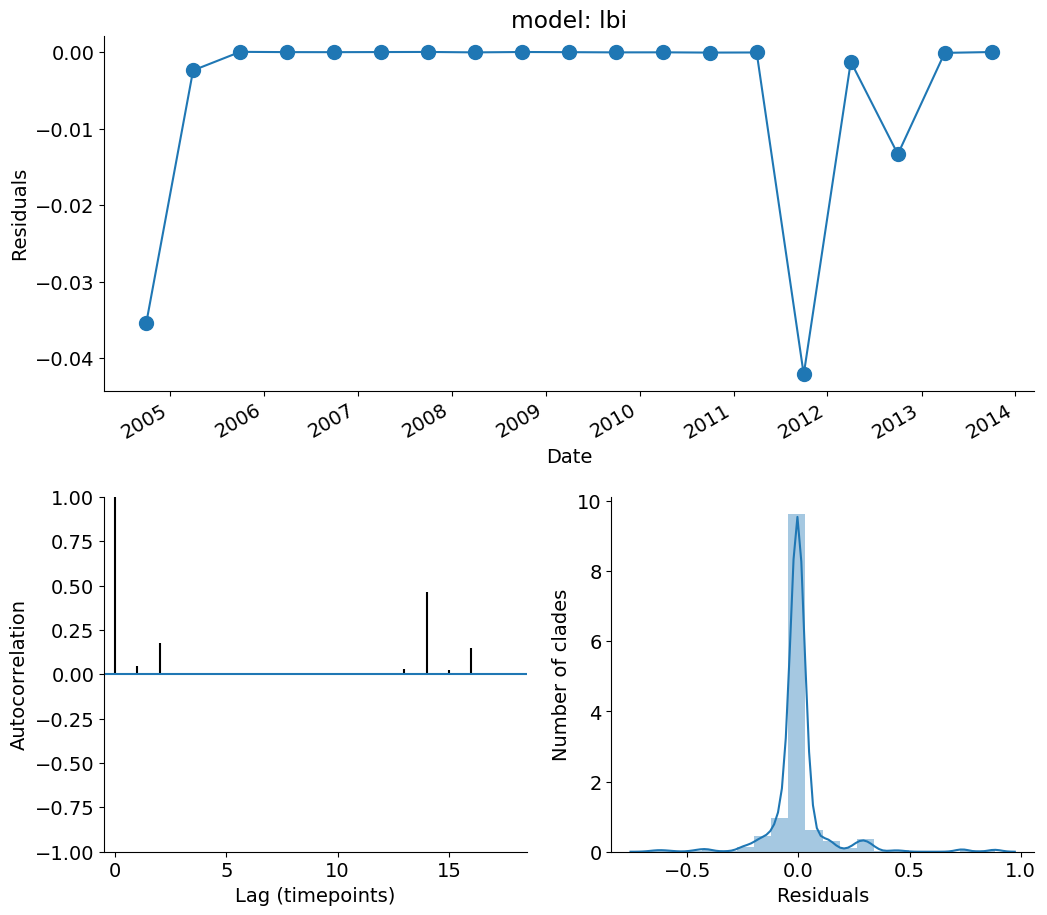

In [374]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [375]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,2f64328,0.000000,2004-10-01,0.072527,-0.072527,2011-10-01,dms_star
1,66684e0,0.000000,2004-10-01,0.004723,-0.004723,2011-10-01,dms_star
2,84dfd90,0.000227,2004-10-01,0.020424,-0.020197,2011-10-01,dms_star
3,8f3fc76,0.018687,2004-10-01,0.120410,-0.101723,2011-10-01,dms_star
4,dffb0cc,0.000000,2004-10-01,0.013805,-0.013805,2011-10-01,dms_star


### Residuals by predictor

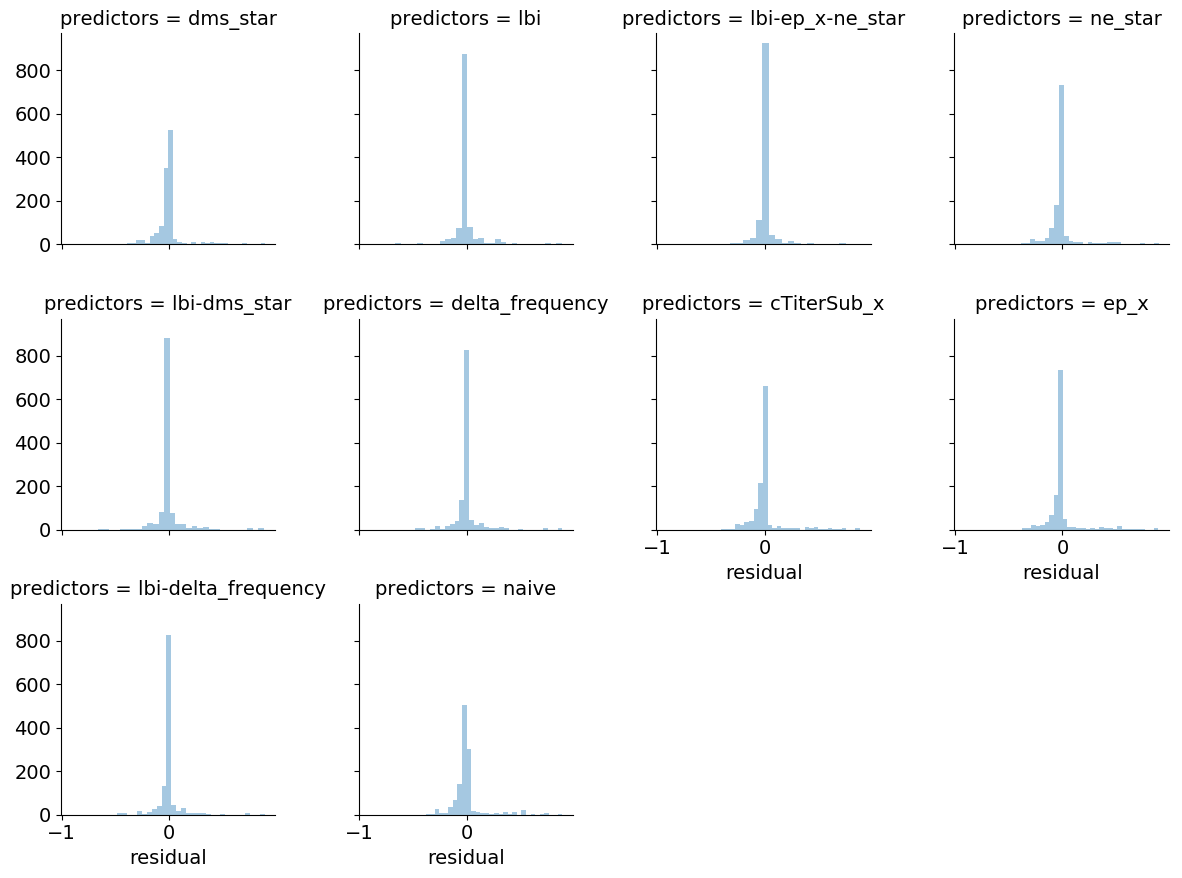

In [376]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=30, kde=False)

In [377]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive                 -0.006578
ep_x                  -0.006571
cTiterSub_x           -0.005787
ne_star               -0.005557
dms_star              -0.005147
lbi-delta_frequency   -0.001875
delta_frequency       -0.001858
lbi                   -0.001372
lbi-dms_star          -0.001011
lbi-ep_x-ne_star      -0.000217
Name: residual, dtype: float64

In [378]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiterSub_x            1227
delta_frequency        1227
dms_star               1227
ep_x                   1227
lbi                    1227
lbi-delta_frequency    1227
lbi-dms_star           1227
lbi-ep_x-ne_star       1227
naive                  1227
ne_star                1227
Name: residual, dtype: int64

In [379]:
(residual_df["residual"] < -0.01).sum()

4434

### Residuals by timepoint

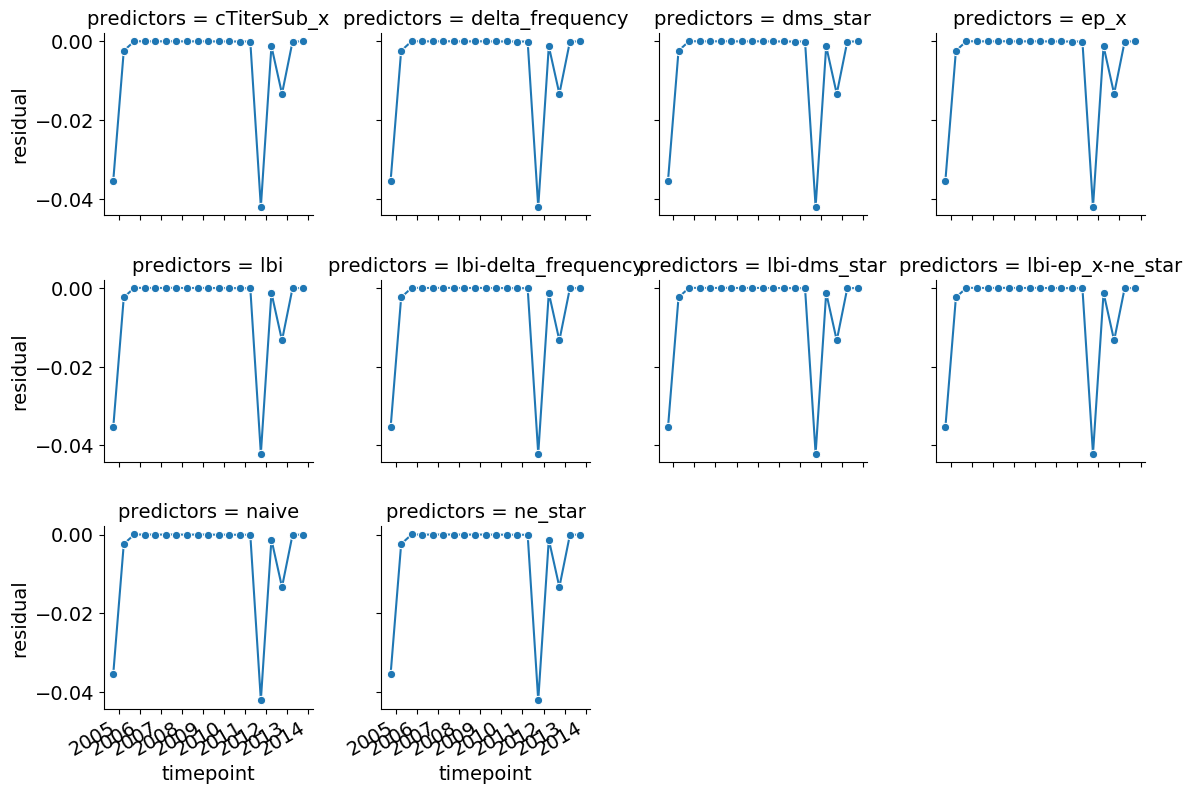

In [380]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [381]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([5.55111512e-17, 2.98372438e-16, 2.56739074e-16, 6.48786580e-16,
       2.84237152e-16, 8.18572640e-16, 2.85042172e-15, 5.75928194e-16,
       5.16600651e-15, 8.96852037e-16, 2.99760217e-15, 1.00267017e-15,
       3.72965547e-16, 8.11200065e-16, 1.83186799e-15, 6.39462441e-16,
       3.98986399e-16, 4.22012143e-16, 1.39211559e-16])

### Autocorrelation of residuals

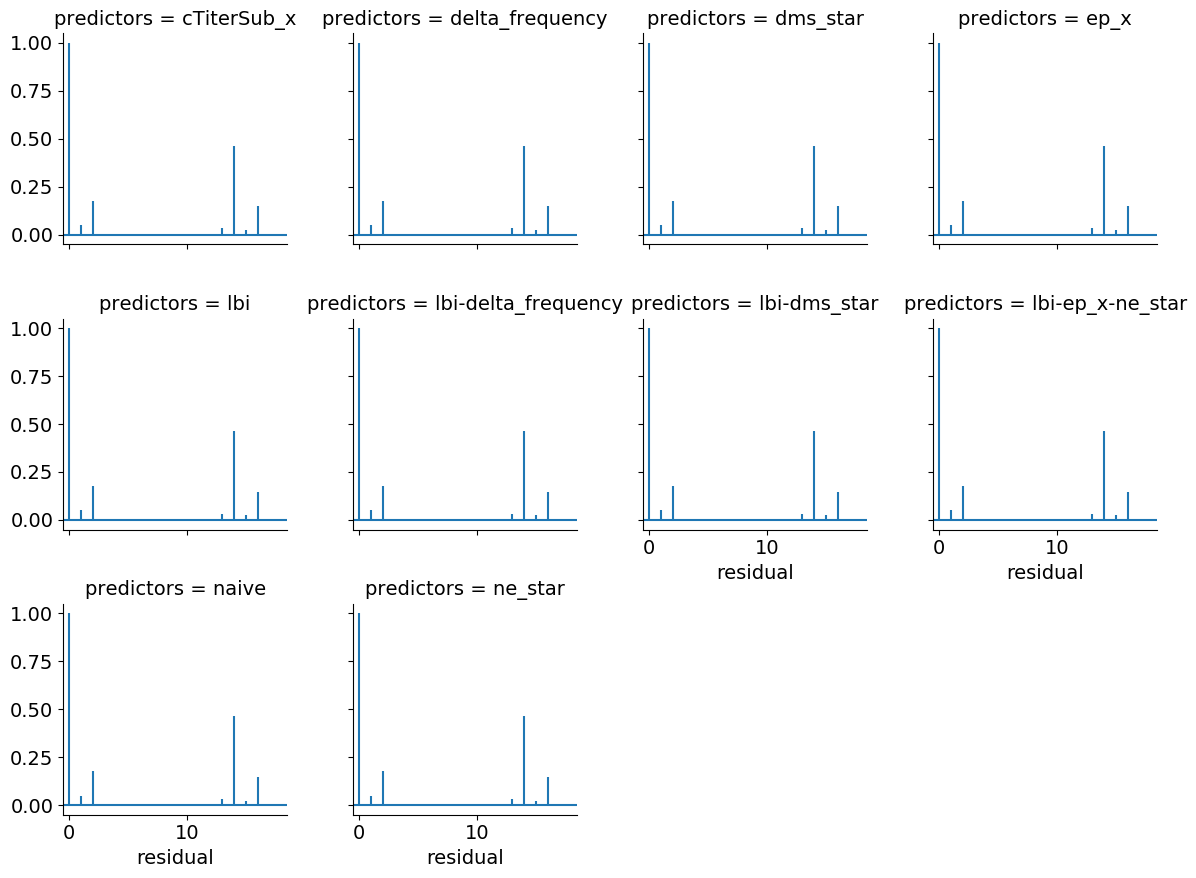

In [382]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates

### Observed and predicted frequencies

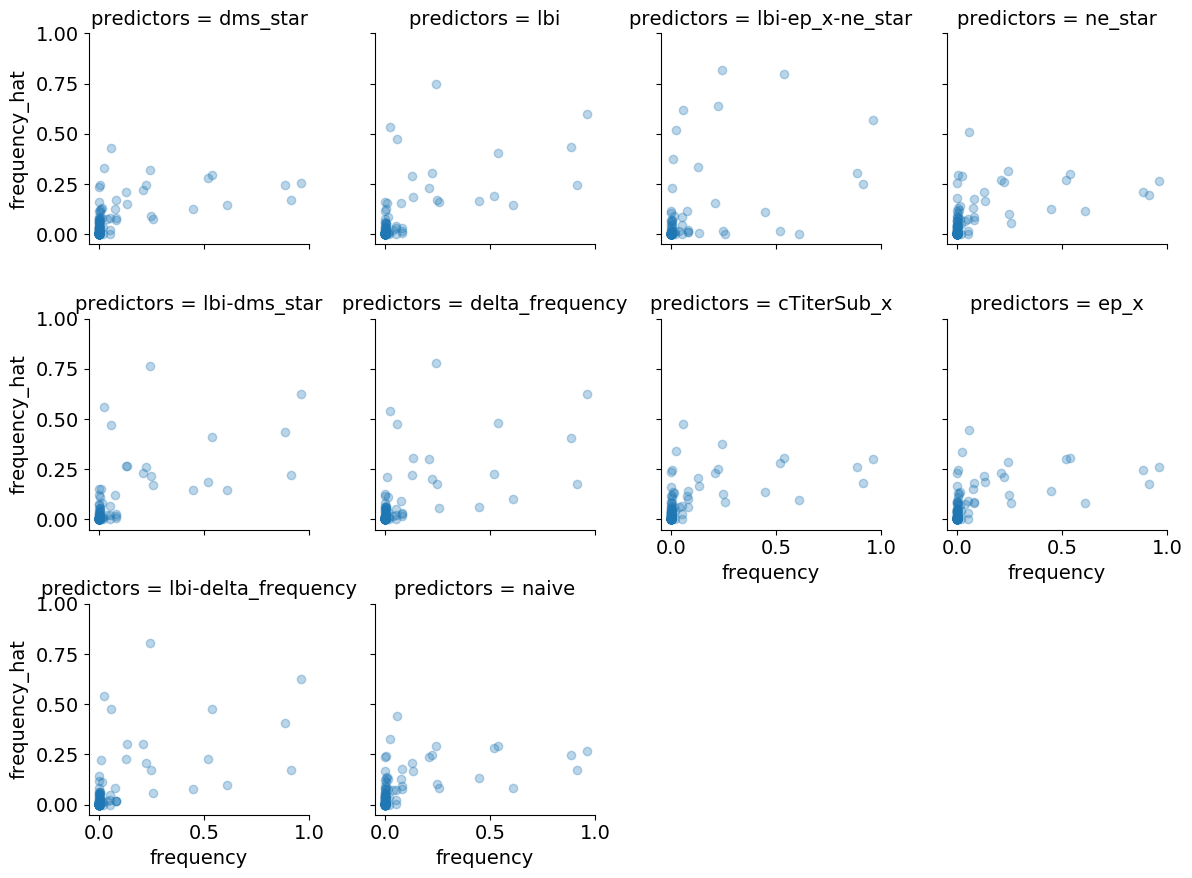

In [383]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

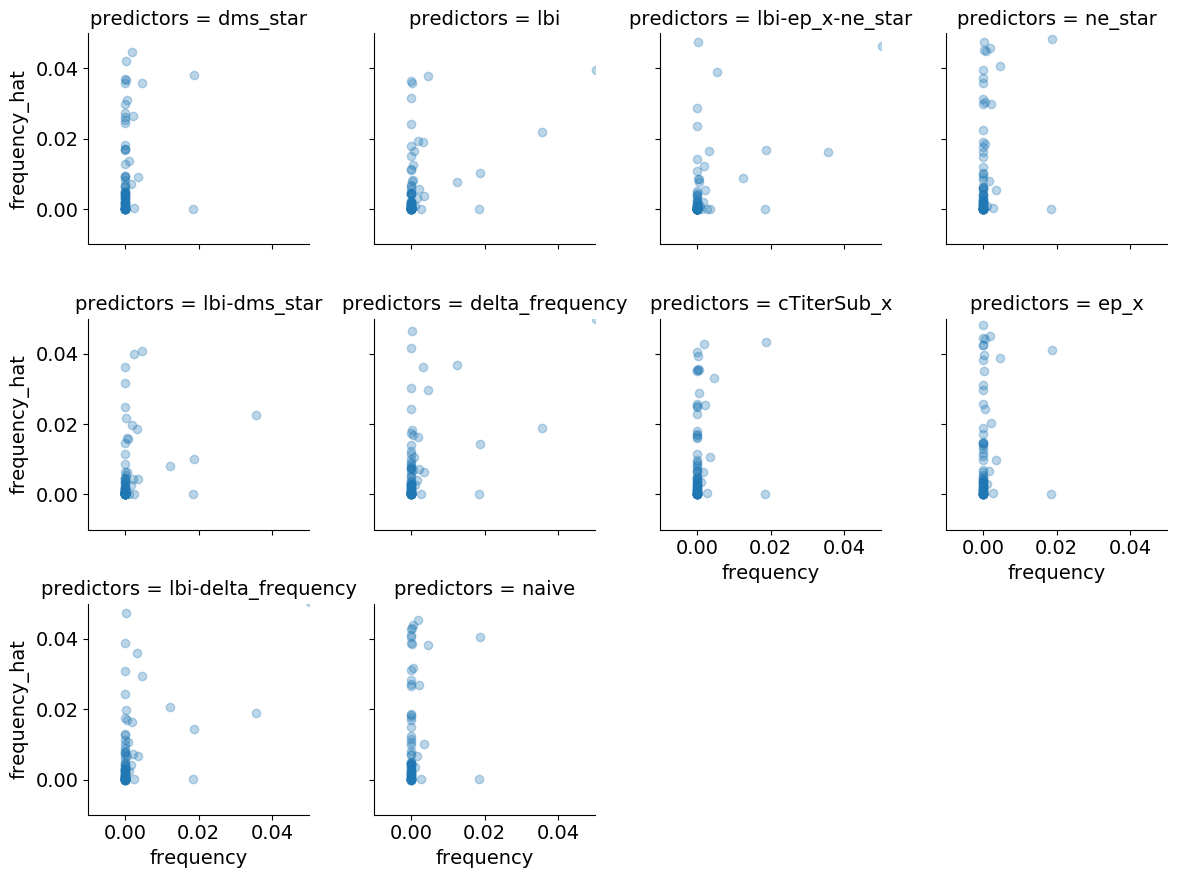

In [384]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.05)
    ax.set_ylim(-0.01, 0.05)

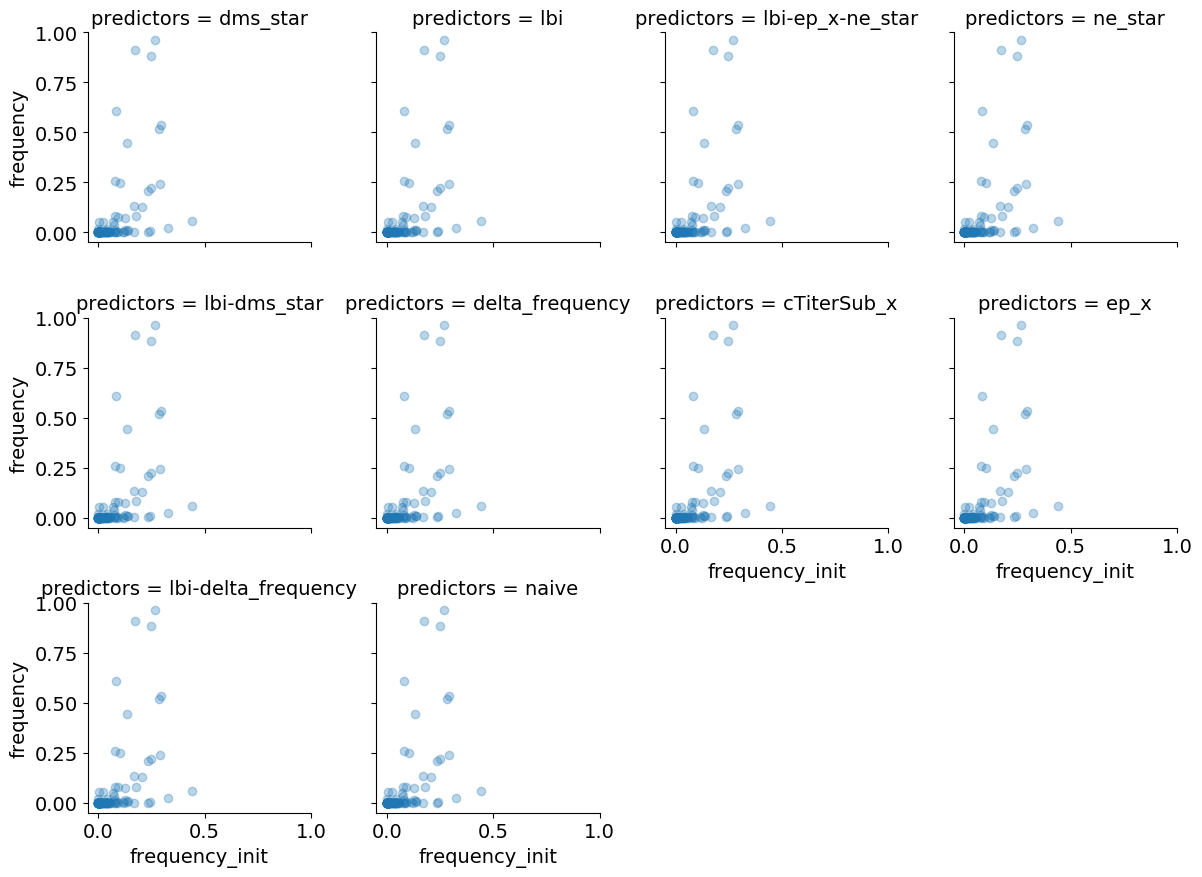

In [385]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

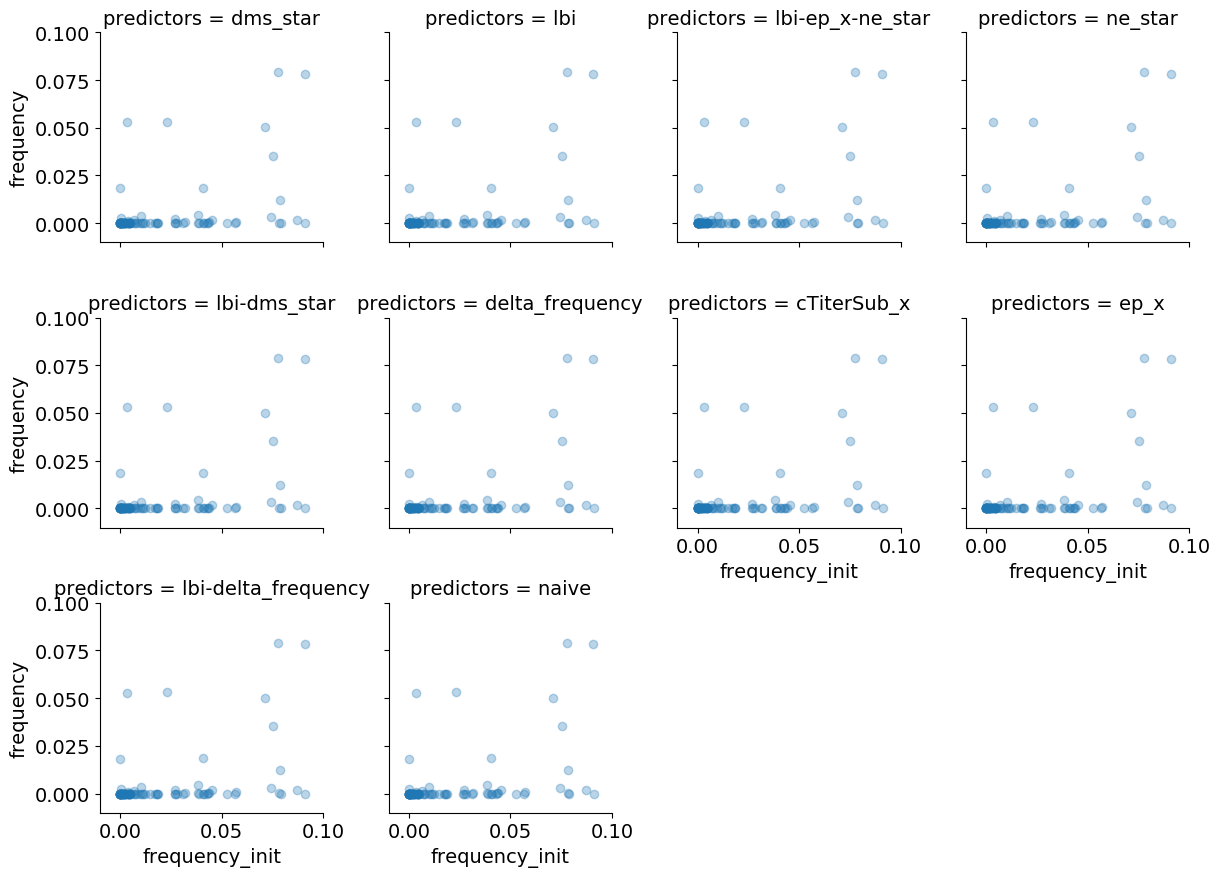

In [386]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=4)
g.map(plt.plot, "frequency_init", "frequency", marker="o", linestyle="", alpha=0.3)

for ax in g.axes.flatten():
    ax.set_xlim(-0.01, 0.1)
    ax.set_ylim(-0.01, 0.1)

In [387]:
frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

(116,)

In [388]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency"] == 0.0).sum()

63

In [389]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum()

51

In [390]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.01).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.43965517])

In [391]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum()

77

In [392]:
(frequency_df[frequency_df["predictors"] == "lbi"]["frequency_init"] < 0.05).sum() / frequency_df[frequency_df["predictors"] == "lbi"]["frequency"].shape

array([0.6637931])

### Observed and predicted growth rates

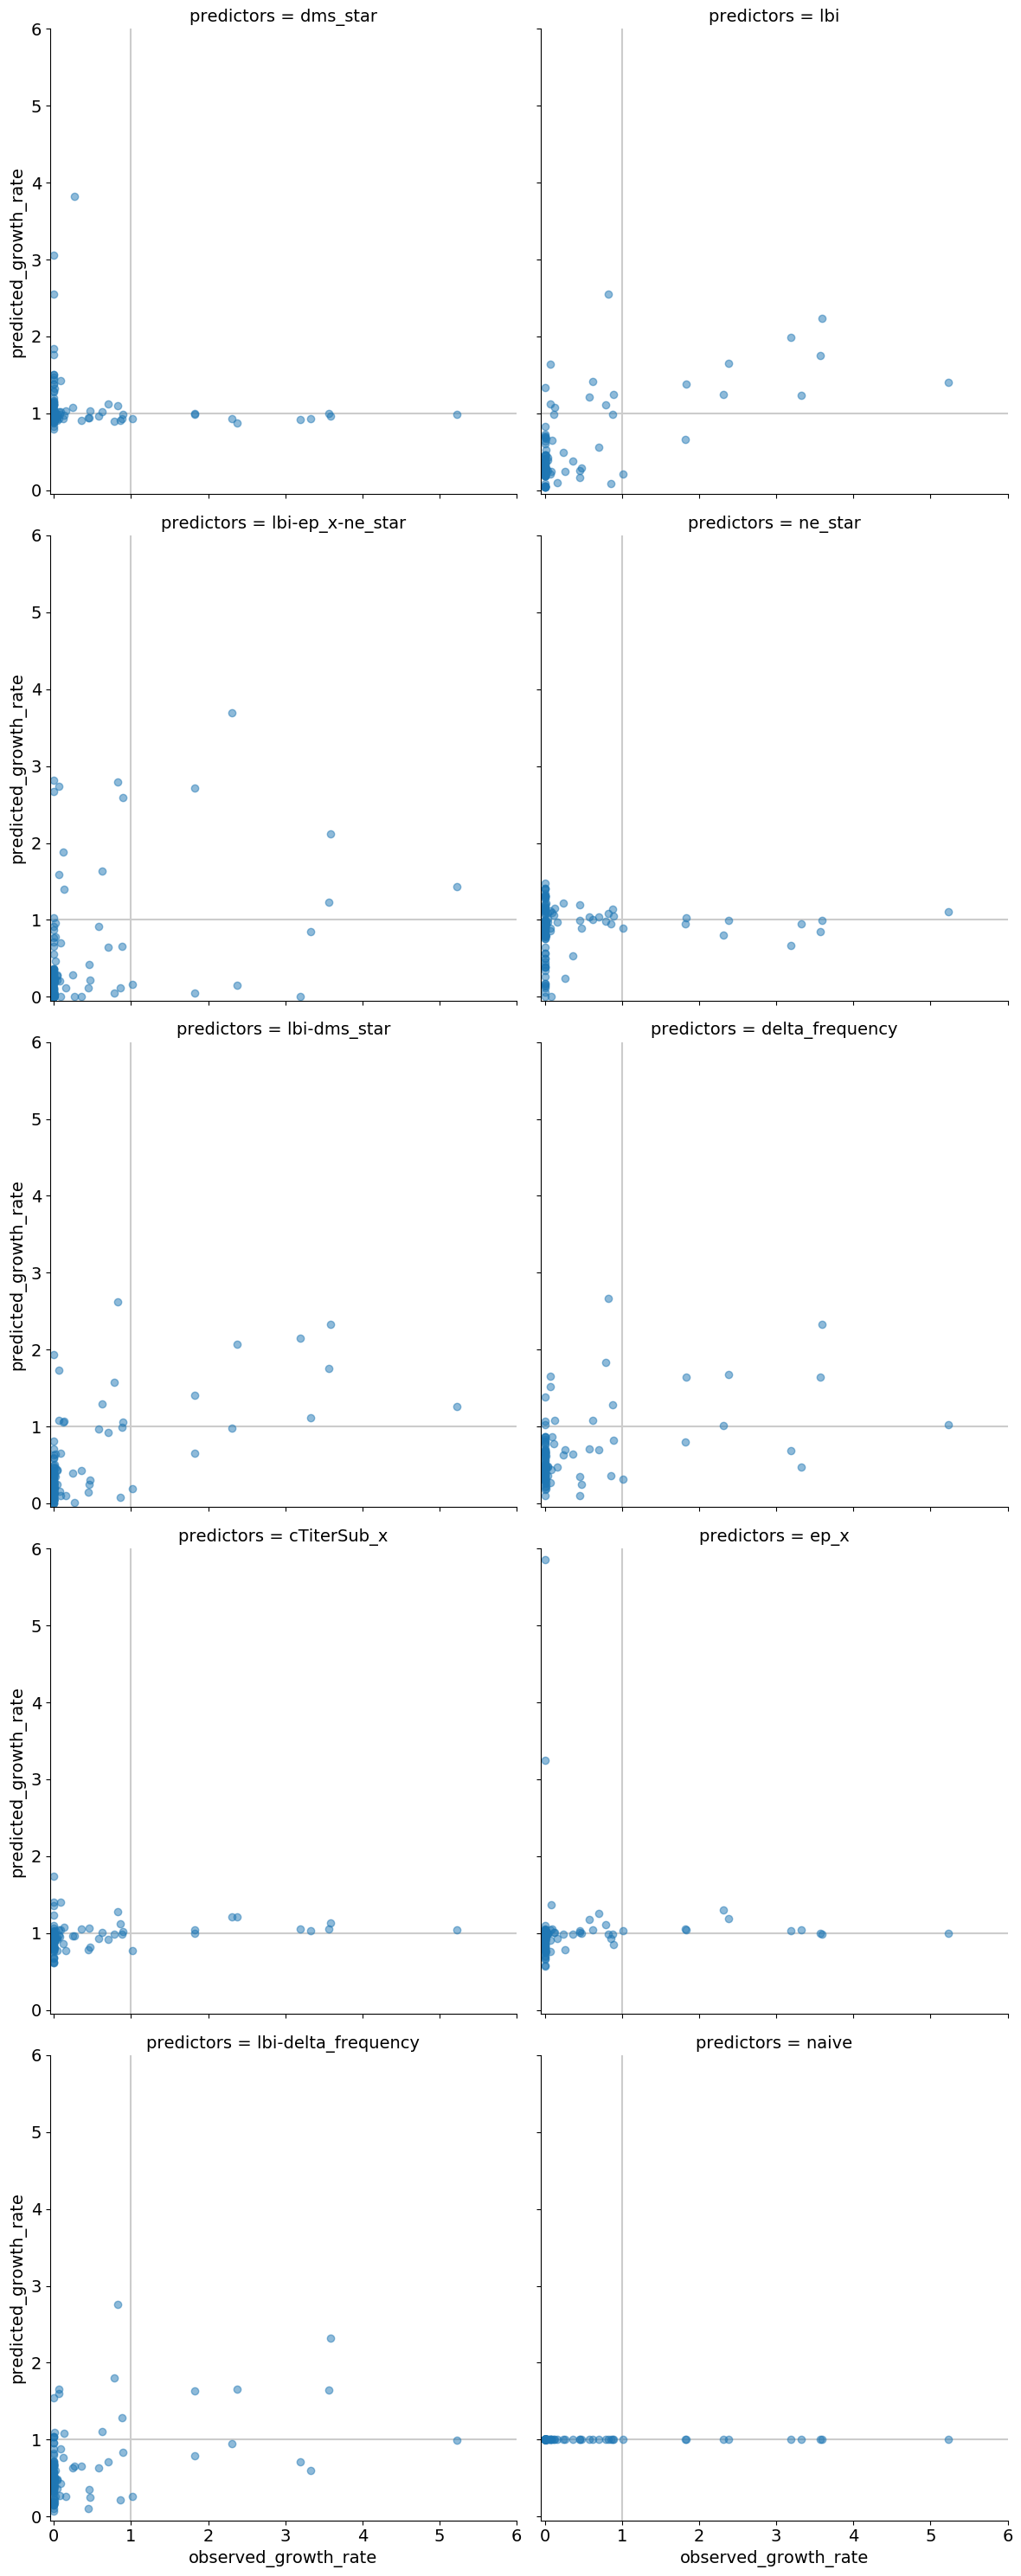

In [393]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

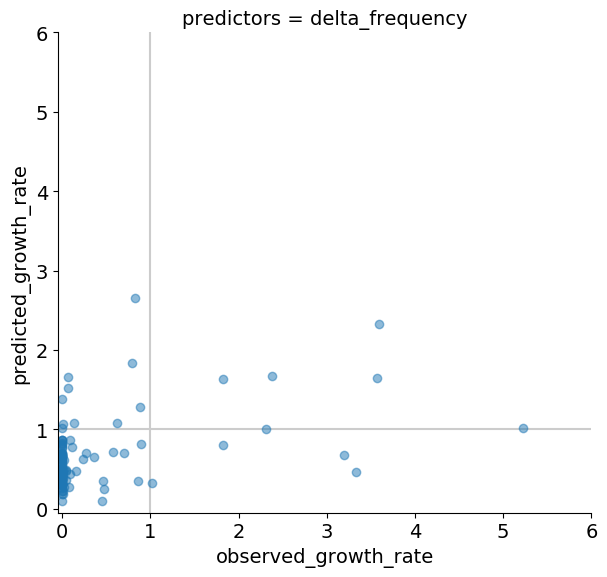

In [394]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

In [395]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0fdda1d,0.000000,2011-10-01,0.000978,0.001061,-0.000978,0.000000,0.921314,2011-10-01,dms_star
1,192d067,0.000005,2011-10-01,0.058473,0.052599,-0.058468,0.000095,1.111670,2011-10-01,dms_star
2,1cae6ee,0.000000,2011-10-01,0.000091,0.000103,-0.000091,0.000000,0.882556,2011-10-01,dms_star
3,1de1231,0.241074,2011-10-01,0.321393,0.292106,-0.080319,0.825296,1.100262,2011-10-01,dms_star
4,3c30c21,0.000000,2011-10-01,0.004243,0.004617,-0.004243,0.000000,0.919007,2011-10-01,dms_star


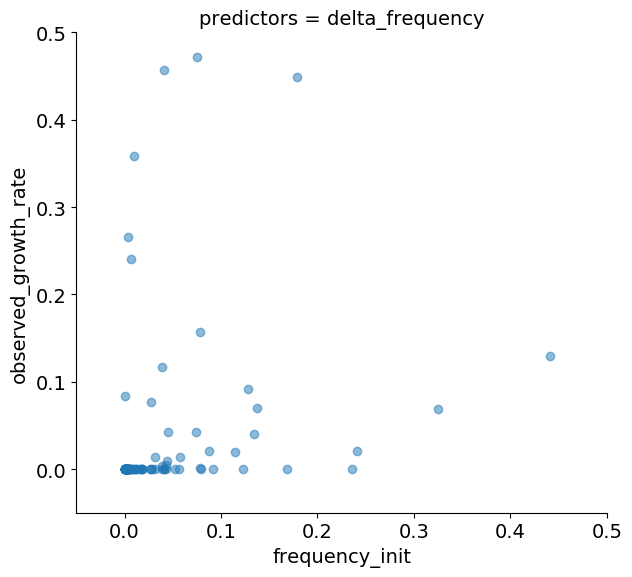

In [396]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "frequency_init", "observed_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 0.5)
    ax.set_ylim(-0.05, 0.5)

In [397]:
frequency_df.loc[frequency_df["observed_growth_rate"].idxmax()]

clade_membership                     a9fbbd4
frequency                           0.018322
timepoint                2012-10-01 00:00:00
frequency_hat                    5.90018e-05
frequency_init                       5.1e-05
residual                            0.018263
observed_growth_rate                 359.255
predicted_growth_rate                 1.1569
validation_timepoint     2012-10-01 00:00:00
predictors                          dms_star
Name: 48, dtype: object

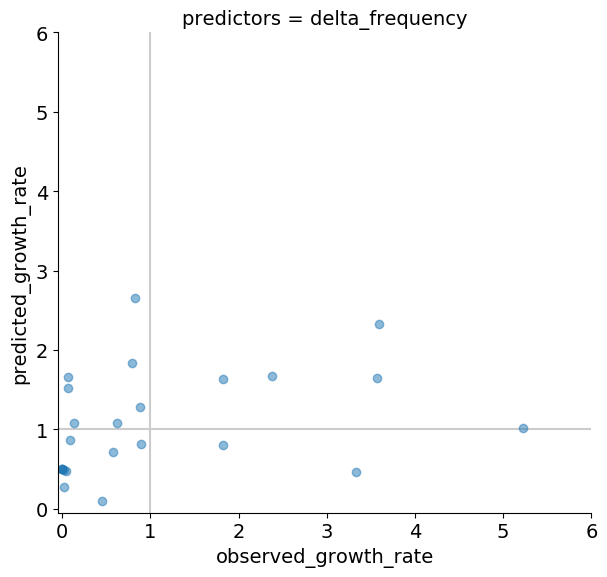

In [398]:
g = sns.FacetGrid(frequency_df[(frequency_df["predictors"] == "delta_frequency") & (frequency_df["frequency_init"] > 0.1)], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

## Summarize model forecasting error

### Mean absolute error (MAE)

In [399]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [400]:
mae_df.sort_values("mae")

,predictors,mae
6,lbi-dms_star,0.054077
4,lbi,0.054816
1,delta_frequency,0.058050
5,lbi-delta_frequency,0.058284
0,cTiterSub_x,0.064001
3,ep_x,0.064828
2,dms_star,0.065459
8,naive,0.065689
9,ne_star,0.066409
7,lbi-ep_x-ne_star,0.069813


In [401]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [402]:
mae_by_timepoint_df.head()

,predictors,validation_timepoint,mae
0,cTiterSub_x,2011-10-01,0.040309
1,cTiterSub_x,2012-04-01,0.077819
2,cTiterSub_x,2012-10-01,0.071564
3,cTiterSub_x,2013-04-01,0.053667
4,cTiterSub_x,2013-10-01,0.033627


In [403]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [404]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

In [405]:
overall_errors_df.head()

,cv_error_mean,cv_error_std,predictors
0,0.353969,0.231497,dms_star
1,0.295691,0.200811,lbi
2,0.462523,0.196765,lbi-ep_x-ne_star
3,0.372064,0.238055,ne_star
4,0.303656,0.224208,lbi-dms_star


(0, 0.07126001657976246)

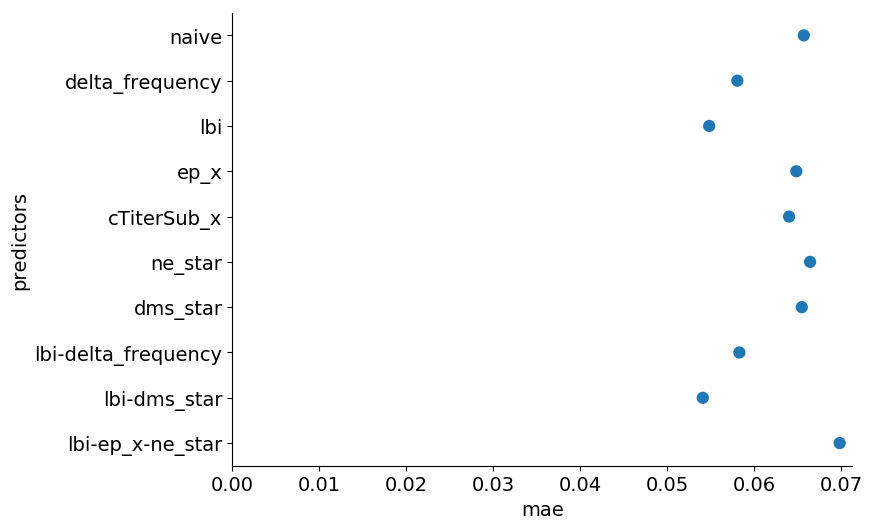

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

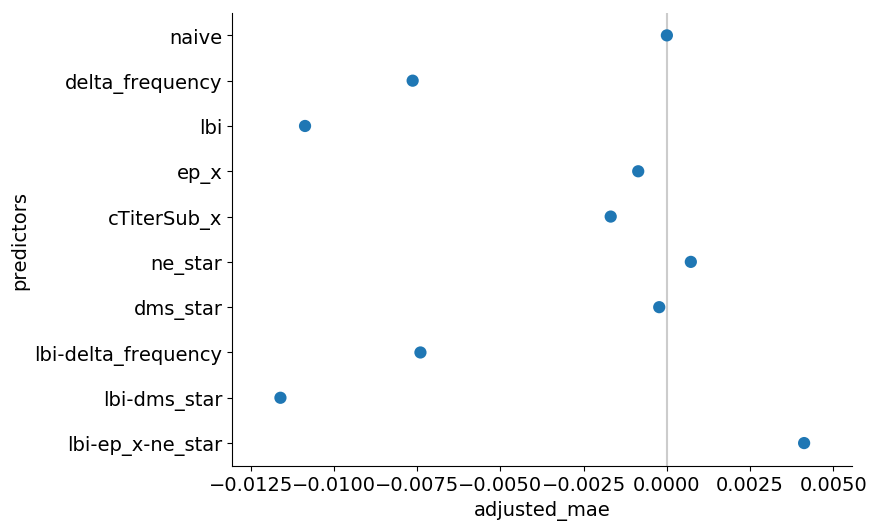

In [409]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

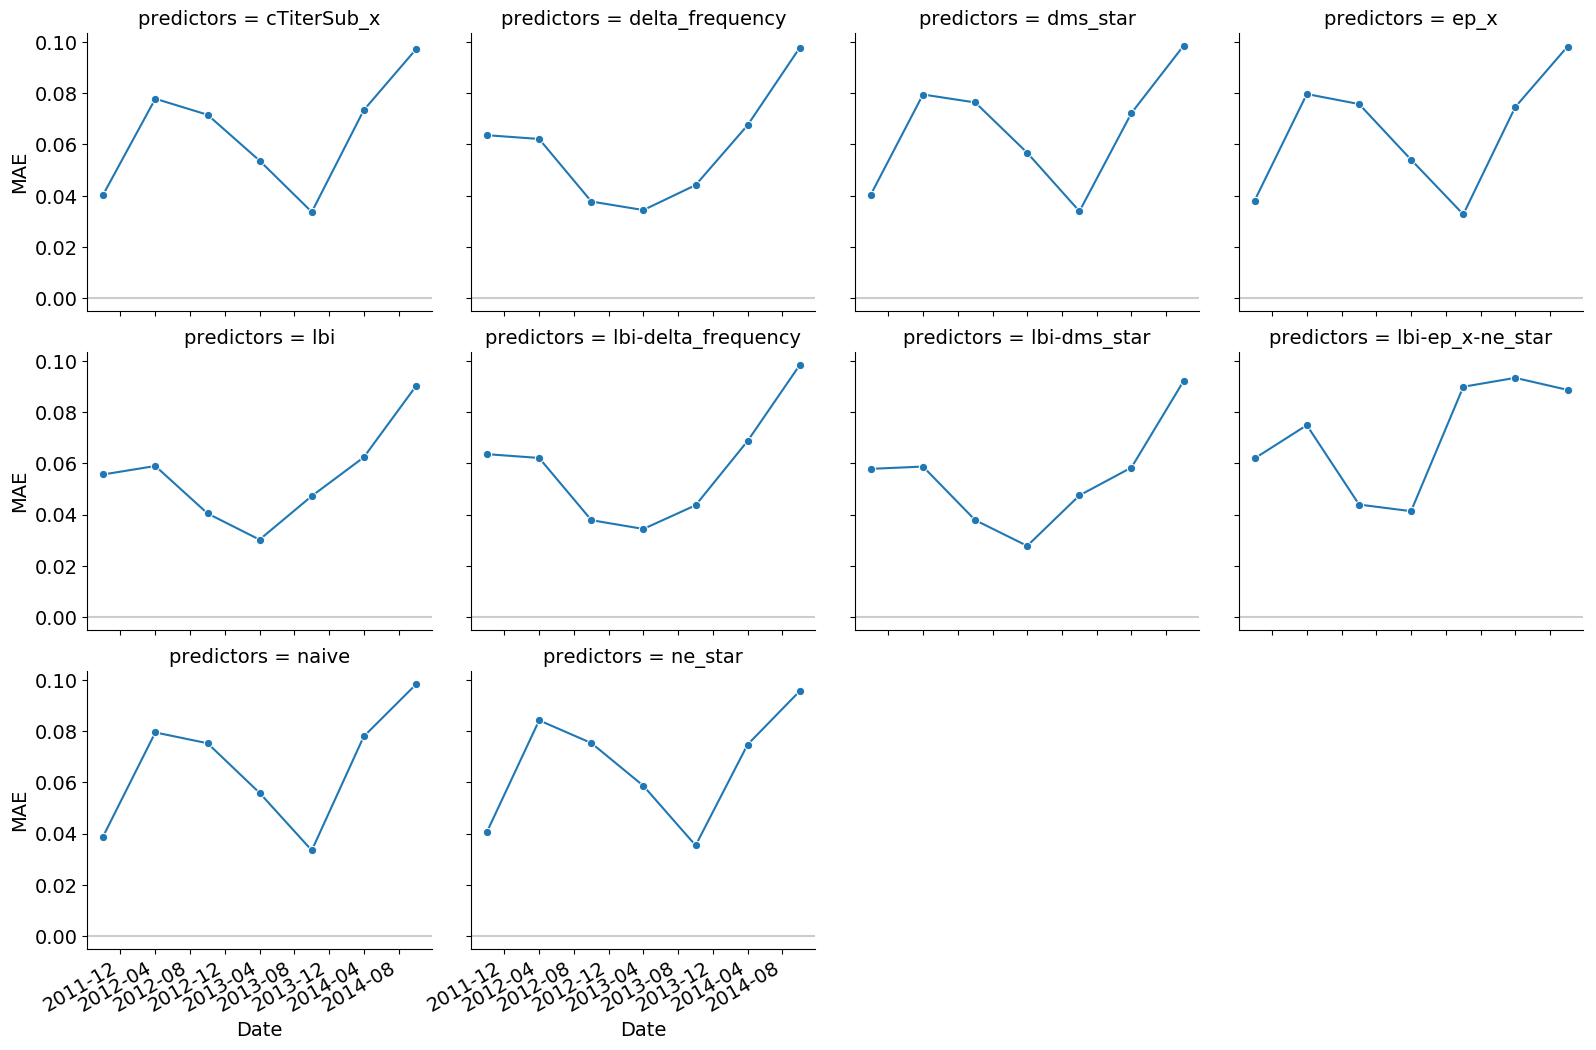

In [410]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

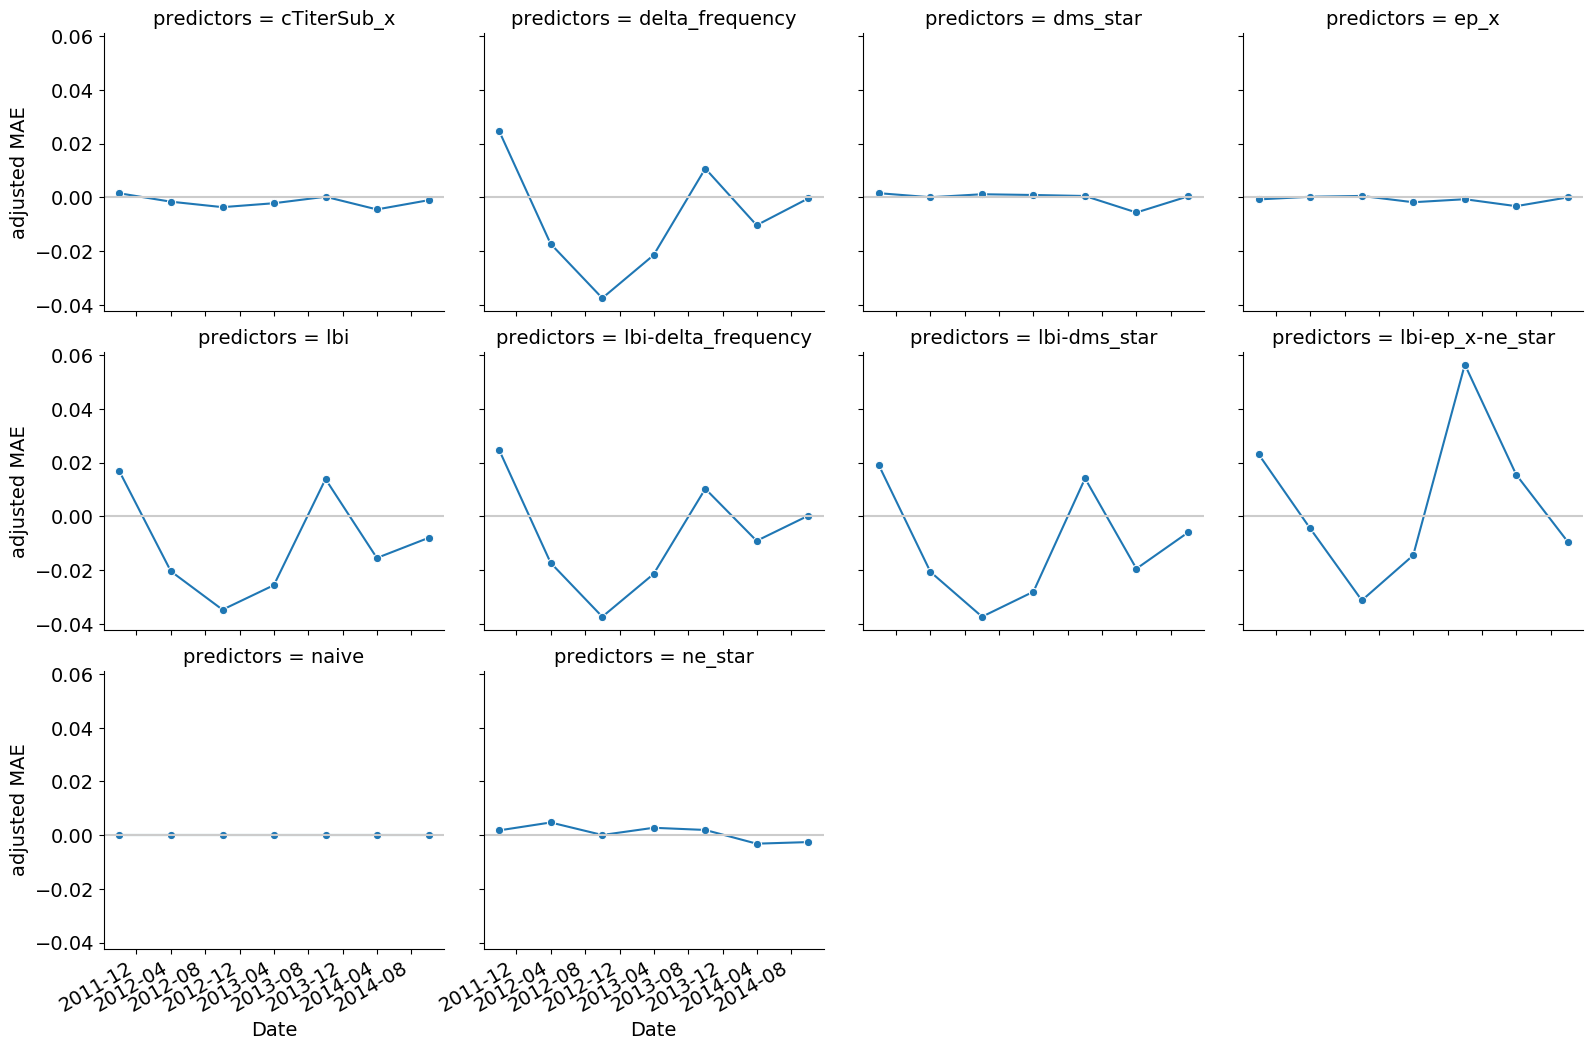

In [411]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "adjusted MAE", timepoint_column="validation_timepoint")

### Root mean square error (RMSE)

In [412]:
rmse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: root_mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "rmse"})

(0, 0.16940017450683198)

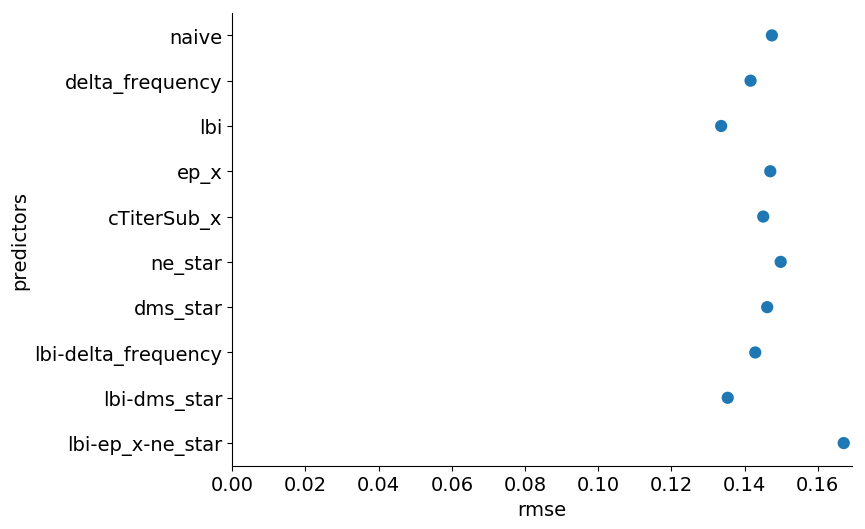

In [413]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="rmse",
    y="predictors",
    data=rmse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

### Mean squared error (MSE)

In [414]:
mse_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [415]:
mse_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_square_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mse"})

In [416]:
naive_mse = mse_by_timepoint_df[mse_by_timepoint_df["predictors"] == "naive"]["mse"].values
for predictor in mse_by_timepoint_df["predictors"].drop_duplicates().values:
    mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "adjusted_mse"] =  mse_by_timepoint_df.loc[mse_by_timepoint_df["predictors"] == predictor, "mse"] - naive_mse

(0, 0.02907465236098483)

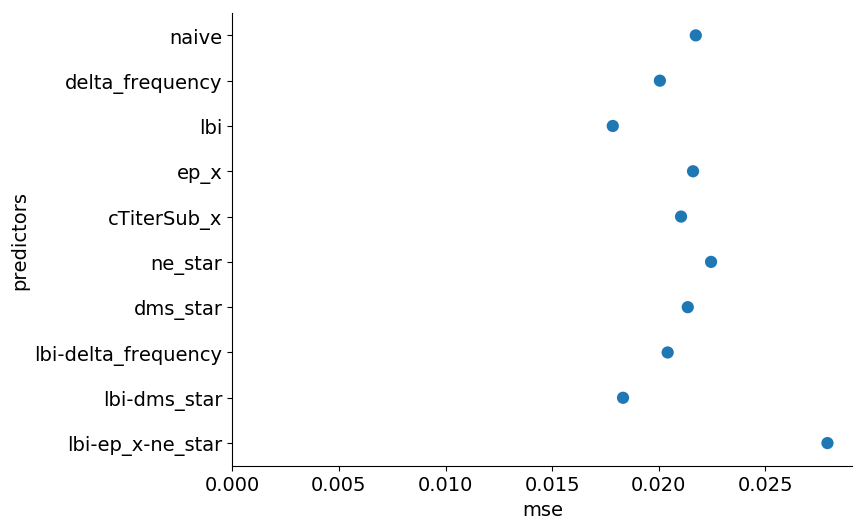

In [417]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mse",
    y="predictors",
    data=mse_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

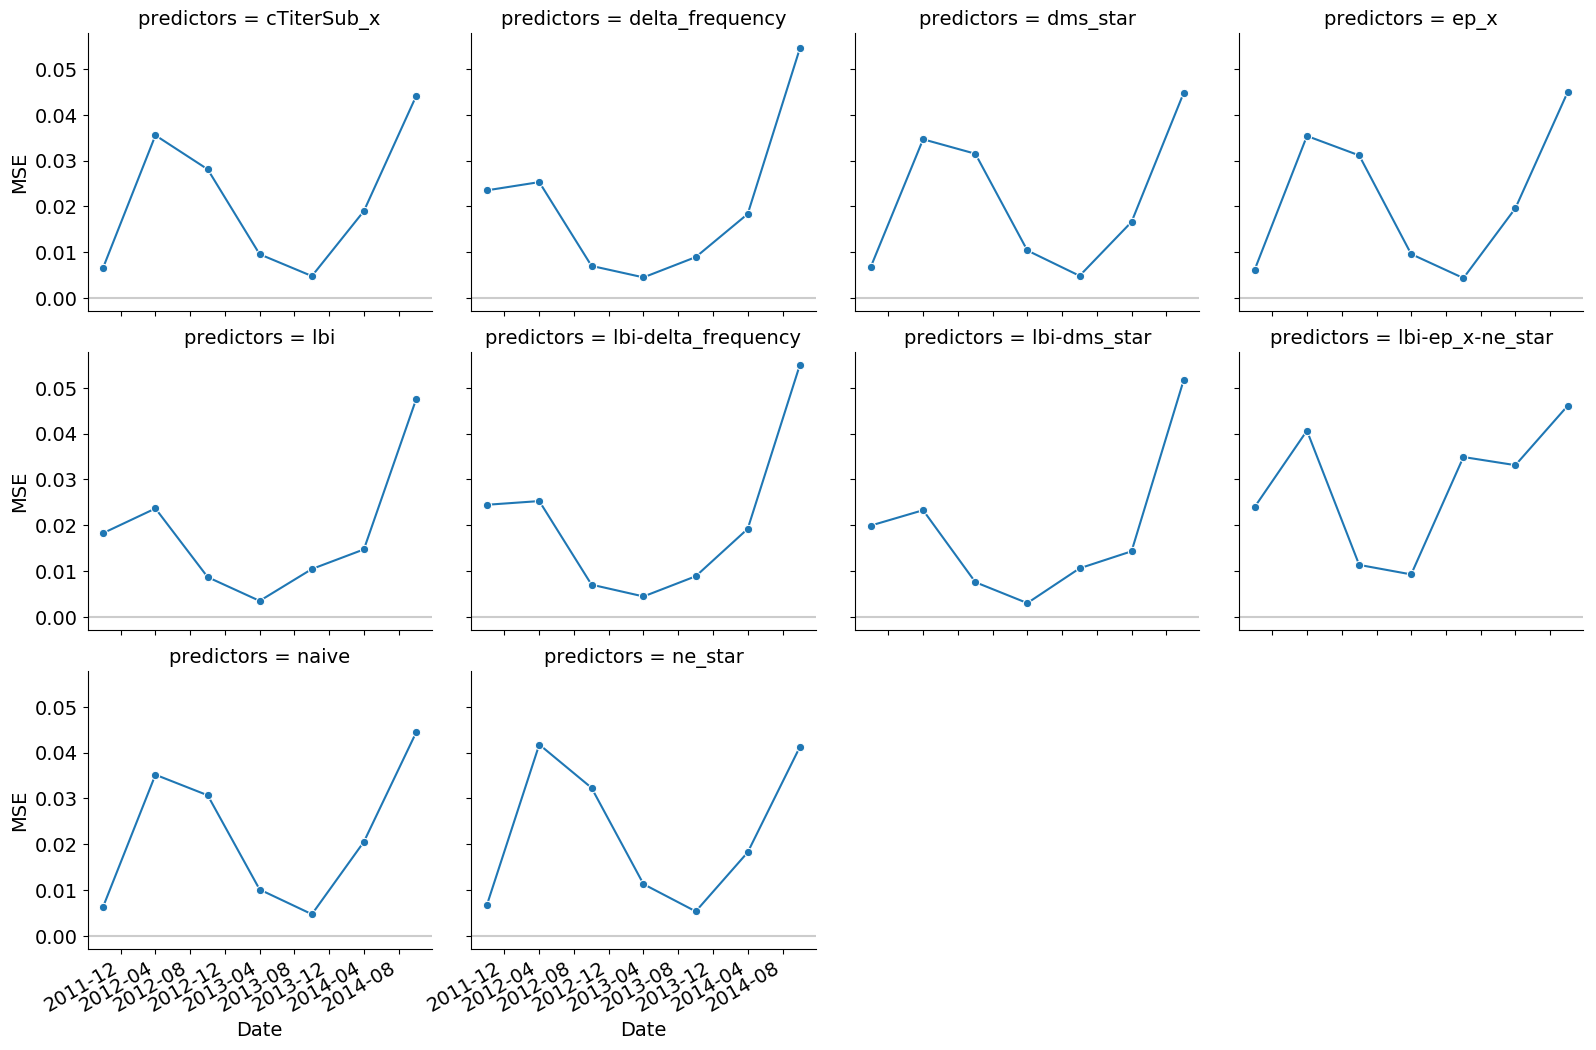

In [418]:
g = facet_time_plot(mse_by_timepoint_df, "mse", "MSE", timepoint_column="validation_timepoint")

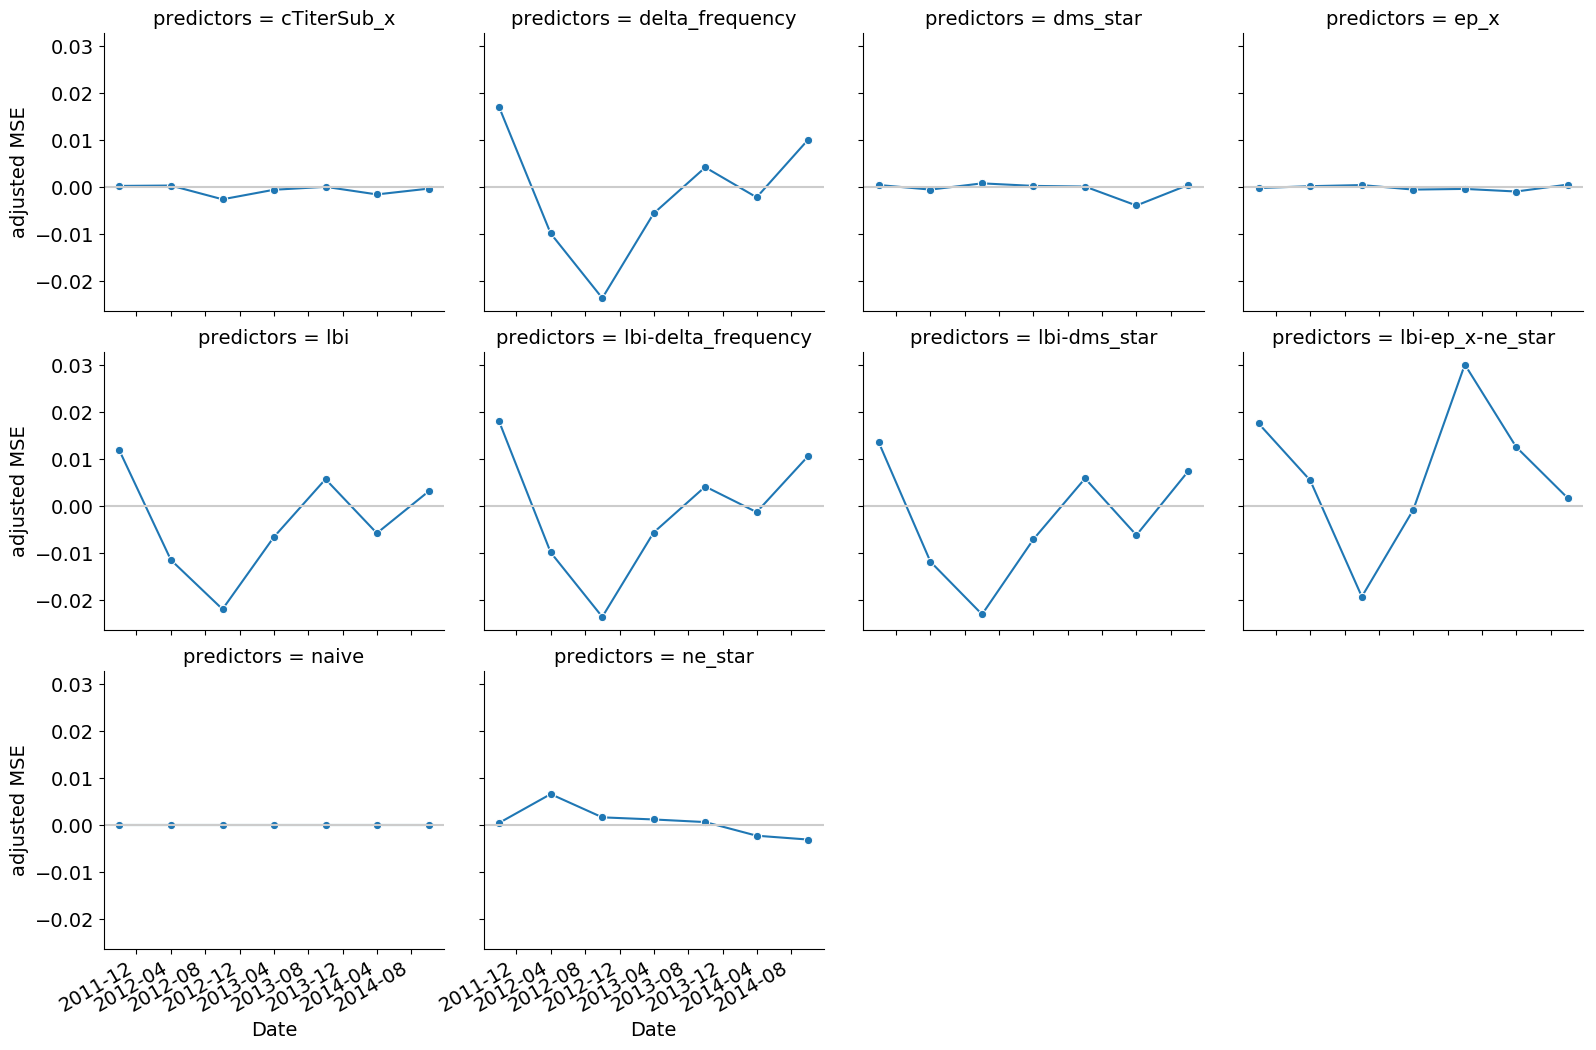

In [419]:
g = facet_time_plot(mse_by_timepoint_df, "adjusted_mse", "adjusted MSE", timepoint_column="validation_timepoint")

(0.0, 0.0579971545911548)

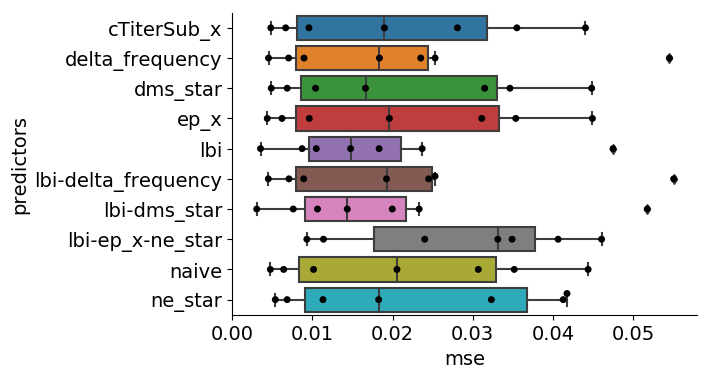

In [431]:
ax = sns.boxplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df
)
ax = sns.swarmplot(
    "mse",
    "predictors",
    data=mse_by_timepoint_df,
    color="black",
    ax=ax
)
ax.set_xlim(left=0.0)

## Summarize model coefficients

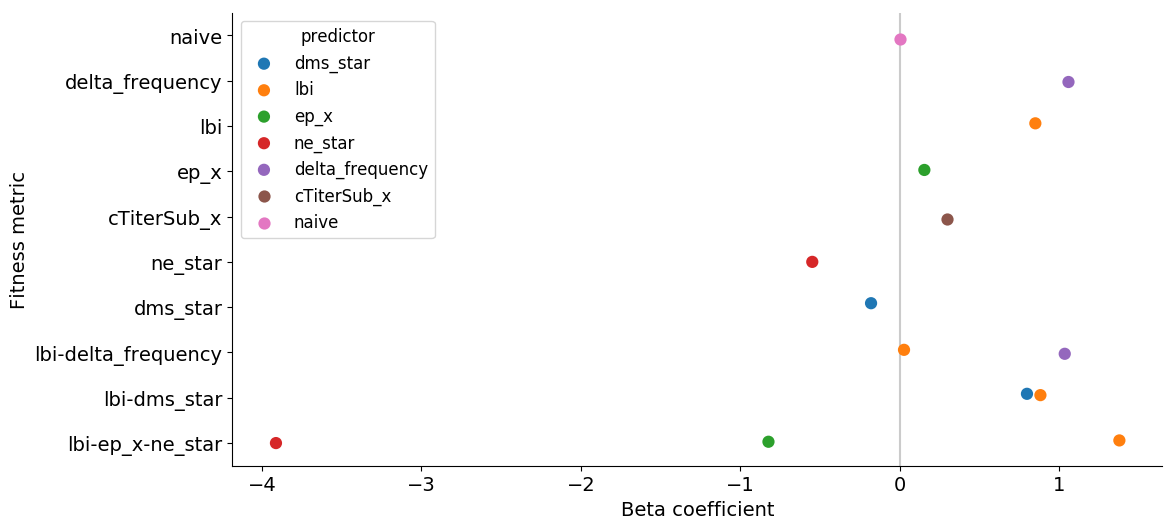

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

In [421]:
coefficients_by_time_df.head()

,coefficient,predictor,predictors,validation_timepoint
0,-0.258994,dms_star,dms_star,2011-10-01
1,-0.258698,dms_star,dms_star,2012-04-01
2,-0.256959,dms_star,dms_star,2012-10-01
3,-0.256990,dms_star,dms_star,2013-04-01
4,-0.250266,dms_star,dms_star,2013-10-01


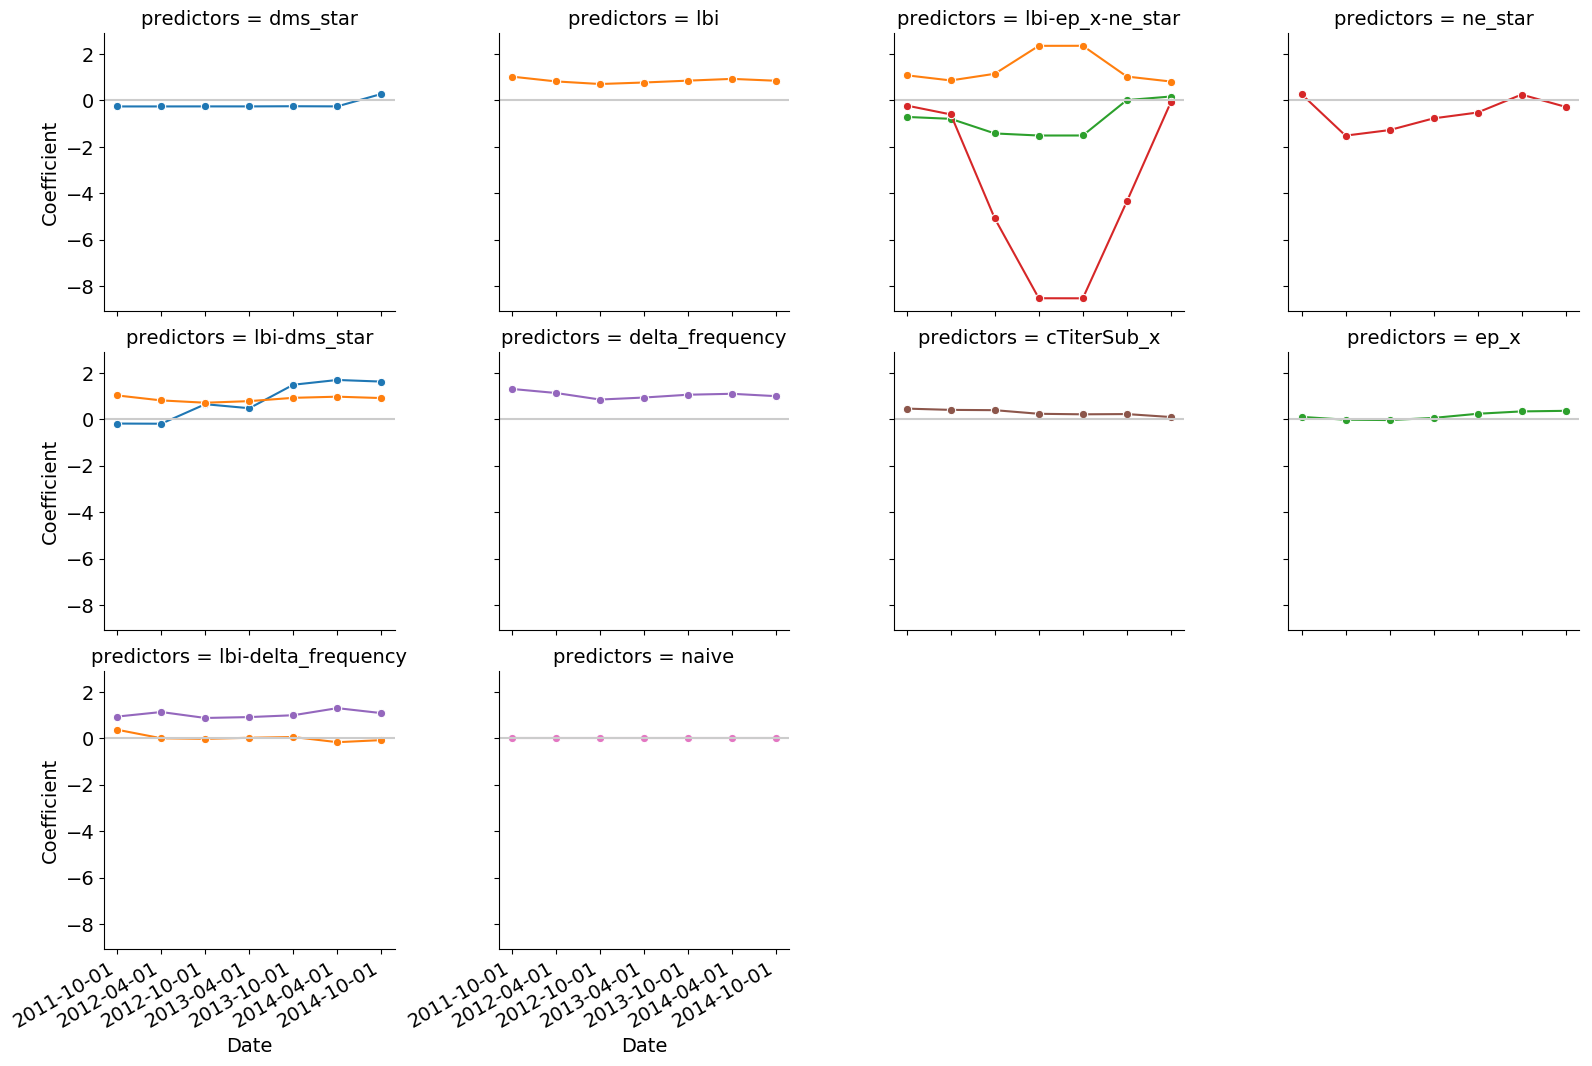

In [422]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint", hue="predictor")